In [1]:
# globals for google colab ot not and others
run_on_colab = True
copy_code_from_drive = True
convert_notebook_to_py = True
copy_code_to_drive = True

In [2]:
if run_on_colab:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if run_on_colab:
  !rm -rf /content/code/output/
  !mkdir -p /content/code/output/
  %cd /content/code/

  #!pwd

  path_to_hw3 = "/content/drive/MyDrive/studies/master/courses/spring_2020_2021/046746_computer_vision/hw_collab/hw3"
  hw3_code = path_to_hw3 + "/code"

  #ls_command = f"ls {hw3_code}"
  #!$ls_command

  if copy_code_from_drive:
    cp_command = f"cp -r {hw3_code}/* ./"
    !$cp_command

  if convert_notebook_to_py:
    !jupyter nbconvert --to python Q2.ipynb --output Q2.py
  
  if copy_code_to_drive:
    cp_command = f"cp ./Q2.py {hw3_code}/"
    !$cp_command
  
  #!ls ./data


/content/code
[NbConvertApp] Converting notebook Q2.ipynb to python
[NbConvertApp] Writing 10075 bytes to Q2.py


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from shared_Q1_Q2 import *
from frame_video_convert import *

def create_dir(path):
  if os.path.exists(path):
    files = glob.glob(path + "/*")
    for f in files:
      os.remove(f)
    os.removedirs(path)
  if not os.path.exists(path):
    os.makedirs(path)


In [5]:
# %% Q2.1

# Convert .mp4 video to .jpg frames 

self_mp4_file_path = "./my_data/self.mp4"
self_dir_path = "./output/self_frames"

create_dir(self_dir_path)
video_to_image_seq(self_mp4_file_path, self_dir_path)


converting video to frames...
total frames:  328


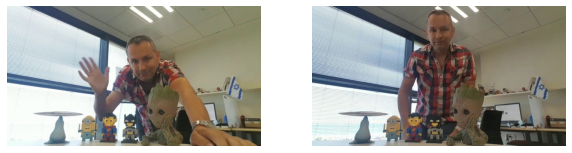

In [6]:
# Showing 2 frames
self_frame1_name = "0050.jpg"
self_frame2_name = "0280.jpg"
self_frame1_file_path = self_dir_path + "/" + self_frame1_name
self_frame2_file_path = self_dir_path + "/" + self_frame2_name
self1 = cv2.cvtColor(cv2.imread(self_frame1_file_path), cv2.COLOR_BGR2RGB)
self2 = cv2.cvtColor(cv2.imread(self_frame2_file_path), cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10,15))
self_images = [self1, self2]
for i,file in enumerate(self_images):
  ax = fig.add_subplot(1, len(self_images),i+1)
  ax.imshow(self_images[i])
  ax.set_axis_off()

In [7]:
# %% Q2.2

# Prepearing the model
# load model
model=torch.hub.load('pytorch/vision:v0.5.0','deeplabv3_resnet101',pretrained=True)
# put in inference mode
model.eval()
# define device
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model.to(device)

# Deep segmentation
segmented_self_dir_path = "./output/segmented_self_frames"
create_dir(segmented_self_dir_path)

self_files = sorted(glob.glob(os.path.join(self_dir_path, '*.jpg')))
for filename in self_files:
  img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
  path, fname = os.path.split(filename)
  seg_img = DeepLabSegmentation(img, model, device, 1)
  cv2.imwrite(os.path.join(segmented_self_dir_path, fname), seg_img)



Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


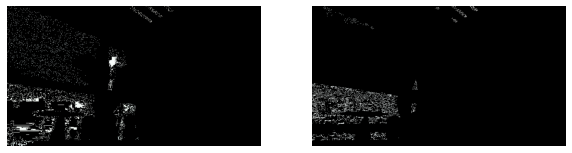

In [8]:
# Showing the 2 segmented frames

seg_self_frame1_file_path = segmented_self_dir_path + "/" + self_frame1_name
seg_self_frame2_file_path = segmented_self_dir_path + "/" + self_frame2_name
seg_self1 = cv2.cvtColor(cv2.imread(seg_self_frame1_file_path), cv2.COLOR_BGR2GRAY)
seg_self2 = cv2.cvtColor(cv2.imread(seg_self_frame2_file_path), cv2.COLOR_BGR2GRAY)


fig = plt.figure(figsize=(10,15))
seg_self_images = [seg_self1, seg_self2]

for i,file in enumerate(seg_self_images):
  ax = fig.add_subplot(1, len(seg_self_images),i+1)
  seg_values, value_counts = np.unique(seg_self_images[i].reshape(-1),axis=0, return_counts=True)
  value_count_sort_ind = np.argsort(value_counts)
  #print(seg_values[value_count_sort_ind])
  #print(value_counts[value_count_sort_ind])
  curClass = seg_values[value_count_sort_ind][-2]
  mask_self = np.zeros_like(seg_self_images[i])
  mask_self[seg_self_images[i] == curClass] = 1
  self_cropped = cropWithRespectToMask(self_images[i], mask_self)
  ax.imshow(self_cropped)
  ax.set_axis_off()

In [9]:
# %% Q2.3

# Convert .mp4 video to .jpg frames

dancing_man_dir_path = "./output/dancing_man_frames"
create_dir(dancing_man_dir_path)
video_to_image_seq("./data/dancing_man_model.mp4", dancing_man_dir_path)

converting video to frames...
total frames:  201


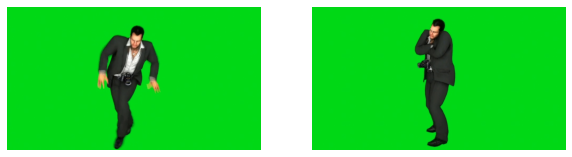

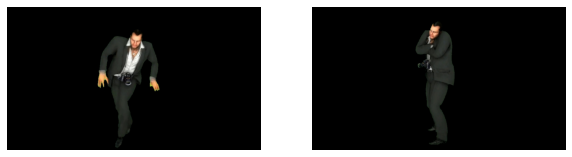

In [10]:
# semantic segmentation using color segmentation

seg_dancing_man_dir_path = "./output/segmented_dancing_man_frames"
create_dir(seg_dancing_man_dir_path)

dancing_man_files = sorted(glob.glob(os.path.join(dancing_man_dir_path, '*.jpg')))

def color_segmentation(hsv_img, bg_hsv_low, bg_hsv_high, erode=False, erode_iterations=1, erode_kernel=None):
  mask = cv2.inRange(hsv_img, bg_hsv_low,bg_hsv_high)
  mask_inv = cv2.bitwise_not(mask)
  if erode:
    if erode_kernel is None:
      erode_kernel = np.ones((5, 5), np.uint8)
    mask_inv = cv2.erode(mask_inv, erode_kernel, iterations=erode_iterations)
  seg_hsv_img = cv2.bitwise_and(hsv_img, hsv_img, mask=mask_inv)
  return seg_hsv_img, mask_inv

for filename in dancing_man_files:
  hsv_img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2HSV)
  path, fname = os.path.split(filename)
  bg_hsv_green_low = (40, 130, 0)
  bg_hsv_green_high = (70, 255, 255)
  seg_hsv_img, _ = color_segmentation(hsv_img, bg_hsv_green_low, bg_hsv_green_high) 
  cv2.imwrite(os.path.join(seg_dancing_man_dir_path, fname), cv2.cvtColor(seg_hsv_img, cv2.COLOR_HSV2BGR))

dancing_man_frame1_name = "0100.jpg"
dancing_man_frame2_name = "0200.jpg"
dancing_man_frame1_file_path = dancing_man_dir_path + "/" + dancing_man_frame1_name
dancing_man_frame2_file_path = dancing_man_dir_path + "/" + dancing_man_frame2_name
dancing_man1 = cv2.cvtColor(cv2.imread(dancing_man_frame1_file_path), cv2.COLOR_BGR2RGB)
dancing_man2 = cv2.cvtColor(cv2.imread(dancing_man_frame2_file_path), cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10,15))
dancing_man_images = [dancing_man1, dancing_man2]
for i,file in enumerate(dancing_man_images):
  ax = fig.add_subplot(1, len(dancing_man_images),i+1)
  ax.imshow(dancing_man_images[i])
  ax.set_axis_off()

seg_dancing_man_frame1_file_path = seg_dancing_man_dir_path + "/" + dancing_man_frame1_name
seg_dancing_man_frame2_file_path = seg_dancing_man_dir_path + "/" + dancing_man_frame2_name
seg_dancing_man1 = cv2.cvtColor(cv2.imread(seg_dancing_man_frame1_file_path), cv2.COLOR_BGR2RGB)
seg_dancing_man2 = cv2.cvtColor(cv2.imread(seg_dancing_man_frame2_file_path), cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10,15))
seg_dancing_man_images = [seg_dancing_man1, seg_dancing_man2]
for i,file in enumerate(seg_dancing_man_images):
  ax = fig.add_subplot(1, len(seg_dancing_man_images),i+1)
  ax.imshow(seg_dancing_man_images[i])
  ax.set_axis_off()


In [11]:
# %% Q2.4

# read background image

pink_floyd_bg_file_path = "./my_data/pink_floyd.jpg"
pink_floyd_bg_img = cv2.imread(pink_floyd_bg_file_path)

def scale_image(img, scale_percent):
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def add_fg_image(bg_img, roi_fg, roi_fg_mask, y_offset, x_offset):
  height, width, channels = roi_fg.shape
  roi = bg_img[y_offset:(y_offset+height), x_offset:(x_offset+width)]
  roi_fg_inv_mask = cv2.bitwise_not(roi_fg_mask)
  roi_bg = cv2.bitwise_or(roi, roi, mask=roi_fg_inv_mask)
  final_roi = cv2.add(roi_bg,roi_fg)
  bg_img[y_offset:(y_offset+height), x_offset:(x_offset+width)] = final_roi

# scale, segment and add hand image to background image

hand_file_path = "./my_data/hand.jpg"
hand_img = cv2.imread(hand_file_path)
#print('Original hand dimensions : ',hand_img.shape)
resized_hand_img = scale_image(hand_img, scale_percent=60)
bg_hsv_low = (0,0,238)
bg_hsv_high = (255,14,255)
hsv_hand_img = cv2.cvtColor(resized_hand_img, cv2.COLOR_BGR2HSV)
seg_hsv_hand_img, seg_hand_mask = color_segmentation(hsv_hand_img, bg_hsv_low, bg_hsv_high)
roi_fg = cv2.cvtColor(seg_hsv_hand_img, cv2.COLOR_HSV2BGR)
hand_x_offset = 600
hand_y_offset = 300
add_fg_image(pink_floyd_bg_img, roi_fg, roi_fg_mask=seg_hand_mask, y_offset=hand_y_offset, x_offset=hand_x_offset)

#fig = plt.figure(figsize=(10,15))
#ax = fig.add_subplot(1,1,1)
#ax.imshow(cv2.cvtColor(pink_floyd_bg_img, cv2.COLOR_BGR2RGB))
#ax.set_axis_off()
#ax = fig.add_subplot(1,1,1)
#ax.imshow(cv2.cvtColor(roi_bg, cv2.COLOR_BGR2RGB))
#ax.set_axis_off()
#ax = fig.add_subplot(1,1,1)
#ax.imshow(cv2.cvtColor(seg_hsv_hand_img, cv2.COLOR_HSV2RGB))
#ax.set_axis_off()


(810, 456)
writing video...
saved video @  ./output/video.mp4


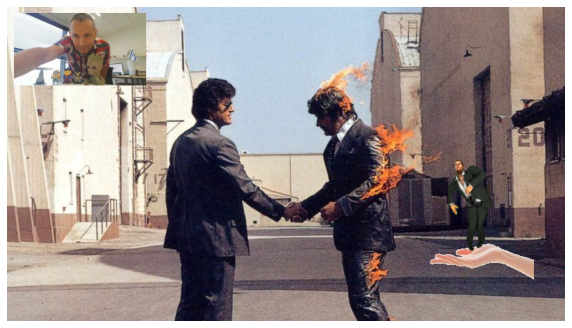

In [22]:
# crop, scale and add dancing man + self images to background and create the clip

final_video_frames_dir_path = "./output/final_video_frames"
create_dir(final_video_frames_dir_path)

dancing_man_files = sorted(glob.glob(os.path.join(dancing_man_dir_path, '*.jpg')))
number_of_dancing_man_files = len(dancing_man_files)

seg_self_files = sorted(glob.glob(os.path.join(segmented_self_dir_path, '*.jpg')))
number_of_seg_self_files = len(seg_self_files)

for i, seg_self_filename in enumerate(seg_self_files):

  curr_bg_img = pink_floyd_bg_img.copy()

  # read segmented self image
  seg_self_img = cv2.cvtColor(cv2.imread(seg_self_filename), cv2.COLOR_BGR2RGB)

  # scale self segmented image
  scaled_seg_self_img = scale_image(seg_self_img,30)

  # add self segmented image to background
  x_offset = 10
  y_offset = 10
  scaled_seg_self_img_gray = cv2.cvtColor(scaled_seg_self_img, cv2.COLOR_RGB2GRAY)
  ret, mask = cv2.threshold(scaled_seg_self_img_gray, 10, 255, cv2.THRESH_BINARY)
  add_fg_image(curr_bg_img, scaled_seg_self_img, mask, y_offset, x_offset)

  str_index_dancing_man_filename = str(i%number_of_dancing_man_files).zfill(4)
  dancing_man_filename = os.path.join(dancing_man_dir_path, str_index_dancing_man_filename + ".jpg")
  dancing_man_img = cv2.imread(dancing_man_filename)

  # horizontal crop
  _, width, _ = dancing_man_img.shape
  cropped_dancing_man_img = dancing_man_img[:, int(width/5):int(width*2/3), :]

  # scale
  scaled_dancing_man_img = scale_image(cropped_dancing_man_img,30)
  #print(scaled_dancing_man_img.shape)

  # color segment
  hsv_dancing_man_img = cv2.cvtColor(scaled_dancing_man_img, cv2.COLOR_BGR2HSV)
  bg_hsv_green_low = (40, 130, 0)
  bg_hsv_green_high = (70, 255, 255)
  seg_hsv_dancing_man_img, mask = color_segmentation(hsv_dancing_man_img, bg_hsv_green_low, bg_hsv_green_high) 
  seg_dancing_man_img = cv2.cvtColor(seg_hsv_dancing_man_img, cv2.COLOR_HSV2BGR)

  # add to background
  x_offset = 600
  y_offset = 200
  add_fg_image(curr_bg_img, seg_dancing_man_img, mask, y_offset, x_offset)

  path, fname = os.path.split(seg_self_filename)
  cv2.imwrite(os.path.join(final_video_frames_dir_path, fname), curr_bg_img)

# create the final video from images
image_seq_to_video(final_video_frames_dir_path, output_path='./output/video.mp4')

fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(1,1,1)
ax.imshow(cv2.cvtColor(curr_bg_img, cv2.COLOR_BGR2RGB))
ax.set_axis_off()